<a href="https://colab.research.google.com/github/rafael-ariascalles/systematically-improving-rag/blob/dev/cohort_2/week1/2.%20benchmark_retrieval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 1: Making Data-Driven Decisions in RAG Applications

> **Prerequisites:** Before starting this notebook, please run the `1. synthetic_questions.ipynb` notebook to generate the evaluation dataset we'll use for our experiments.

When building RAG systems, intuition isn't enough - we need objective metrics to guide our decisions. Teams often waste resources on complex architectures without clear evidence they outperform simpler approaches.

Our own experiments revealed several counterintuitive findings:

1. Embedding search outperformed hybrid search in both recall and MRR metrics
2. Upgrading from `text-embedding-3-small` to `text-embedding-3-large` provided better performance gains than adding a re-ranker
3. For our specific use case, the simpler architecture (pure embedding search) actually performed better than more complex alternatives

This notebook introduces a systematic framework for evaluating and comparing different retrieval strategies.

## Why This Matters

Consider this common scenario: Your team is debating whether to add a re-ranker to your retrieval pipeline. The re-ranker promises better results but adds latency and cost. Without objective metrics, you might invest in unnecessary complexity.

Learning how to objectively measure performance gains is crucial for making informed decisions about your RAG architecture, measure real-world tradeoffs and make evidence-based architectural decisions.

## What you'll learn

Through hands-on experiments with a Text-to-SQL retrieval system, you'll discover:

1. **Understanding Retrieval Metrics**
   - Choose appropriate metrics for your use case
   - Understand tradeoffs between different metrics
   - Learn when to use recall vs MRR
2. **Implementing Evaluation Pipelines**
   - Set up reproducible benchmarks
   - Compare different retrieval strategies
   - Measure performance consistently
3. **Making Data-Driven Decisions**
   - Evaluate cost-benefit tradeoffs
   - Compare architectural alternatives
   - Build evidence-based systems

By the end of this notebook, you'll have a reproducible methodology for evaluating retrieval components and a framework for making data-driven decisions about your RAG architecture.


## Setting up Our Retrieval Pipeline

> **Important** : Please note that your exact scores might differ slightly but in general Text-Embedding-3-Large should outperform Text-Embedding-3-Small along with the re-ranker. This is because you are benchmarking using different questions from mine which you generated in the previous notebook.

In this example, we're using a local `lancedb` instance. We're doing so because of 3 reasons.

1. LanceDB handles the embeddings of our data for us
2. It provides embedding search, hybrid search and other re-ranking methods all within a single api.
3. We can use Pydantic to define our table schema and easily ingest our data.

This makes it quick and easy for us to compare the performance of each method.


In [1]:
%%capture
!pip install datasets
!pip install openai
!pip install instructor
!pip install braintrust
!pip install lancedb
!pip install cohere
!pip install tantivy

In [2]:
import os
from google.colab import userdata


def load_colab_secrets_to_environ(secret_names: list):
  """Loads secrets from Google Colab's secret manager into os.environ."""
  try:
    # Load each secret into os.environ.
    for secret_name in secret_names:
        print("loading {}".format(secret_name))
        os.environ[secret_name] = userdata.get(secret_name)

  except ImportError:
    # If google.colab is not available, assume we're not in Colab.
    pass  # Or handle this case differently if needed

# Load the secrets before using openai
load_colab_secrets_to_environ(
    [
        "OPENAI_API_KEY",
        "HUGGINGFACE_TOKEN",
        "BRAINTRUST_API_KEY",
        "HF_TOKEN",
        "COHERE_API_KEY"
    ]
)

# Rest of your code (import openai, etc.) follows here

loading OPENAI_API_KEY
loading HUGGINGFACE_TOKEN
loading BRAINTRUST_API_KEY
loading HF_TOKEN
loading COHERE_API_KEY


In [3]:
#!rm -r lancedb

In [4]:
import datasets
import lancedb
from lancedb.pydantic import LanceModel, Vector
from lancedb.embeddings import get_registry
from lancedb.table import Table


def get_or_create_lancedb_table(db: Table, table_name: str, embedding_model: str):
    if table_name in db.table_names():
        print(f"Table {table_name} already exists")
        return db.open_table(table_name)

    func = get_registry().get("openai").create(name=embedding_model)

    class Chunk(LanceModel):
        id: str
        query: str = func.SourceField()
        vector: Vector(func.ndims()) = func.VectorField()

    table = db.create_table(table_name, schema=Chunk, mode="overwrite")
    dataset = datasets.load_dataset("567-labs/bird-rag")["train"]
    formatted_dataset = [{"id": item["id"], "query": item["query"]} for item in dataset]
    table.add(formatted_dataset)

    table.create_fts_index("query", replace=True)
    print(f"{table.count_rows()} chunks ingested into the database")
    return table


In [5]:
# Create LanceDB Instance
db = lancedb.connect("./lancedb")
table_small = get_or_create_lancedb_table(
    db, "chunks_text_embedding_3_small", "text-embedding-3-small"
)
table_large = get_or_create_lancedb_table(
    db, "chunks_text_embedding_3_large", "text-embedding-3-large"
)

Table chunks_text_embedding_3_small already exists
Table chunks_text_embedding_3_large already exists


### Defining Metrics

> **Important** : In this case because we have a single relevant chunk, each individual query's recall will be 0 or 1. However, the reason why we have a recall metric below that is between 0 and 1 is because we are taking the average of all these individual recall values we compute for different levels of k

Let's now start by evaluating the retrieval performance of our model. We'll do so by measuring the recall and MRR at different levels of k.

$$ \text{Recall} = \frac{\text{Number of Relevant Items Retrieved}}{\text{Total Number of Relevant Items}} $$

$$ \text{MRR} = \frac{\sum\_{i=1}^{n} \frac{1}{rank(i)}}{n} $$

As models improve, their context window and reasoning abilities improve. This means that their ability to select relevant information in response to a user query will improve. By optimizing for recall, we ensure that the language model has access to all necessary information, which can lead to more accurate and reliable generated responses.

MRR@K is a useful metric if we want to display retrieved results as citations to users. We normally show a smaller list of retrieved results to users and we want to make sure that the correct result is ranked highly during retrieval so that it's more likely to be selected.


In [6]:
def calculate_mrr(predictions_list: list[list[str]], gt_list: list[list[str]]):
    """Calculates the Mean Reciprocal Rank (MRR) for a list of predictions.

    Args:
        predictions_list: A list of lists, where each inner list contains predicted items for a single query.
        gt_list: A list of lists, where each inner list contains ground truth items for a single query.

    Returns:
        The MRR score.
    """
    rr_scores = []
    for predictions, gt in zip(predictions_list, gt_list):
        for i, prediction in enumerate(predictions, 1):  # Start index at 1
            if prediction in gt:
                rr_scores.append(1 / i)
                break  # Break after finding the first relevant item
        else:  # If no relevant items are found for the query
            rr_scores.append(0)

    return sum(rr_scores) / len(rr_scores)  # Calculate the average RR

In [7]:
import numpy as np

def calculate_ndcg(predictions: list[str], gt: list[str], k: int = 10) -> float:
    """Calculates the Normalized Discounted Cumulative Gain (NDCG) at rank k.

    Args:
        predictions: A list of predicted items (strings).
        gt: A list of ground truth items (strings).
        k: The rank at which to calculate NDCG (default is 10).

    Returns:
        The NDCG score (float).
    """

    # Calculate DCG (Discounted Cumulative Gain)
    dcg = 0
    for i, prediction in enumerate(predictions[:k]):
        if prediction in gt:
            relevance = 1  # Assume binary relevance for simplicity
            dcg += relevance / np.log2(i + 2)  # +2 for log base 2 adjustment

    # Calculate IDCG (Ideal Discounted Cumulative Gain)
    ideal_ranking = [label for label in gt if label in predictions]
    ideal_ranking.extend([prediction for prediction in predictions if prediction not in gt])

    idcg = 0
    for i, prediction in enumerate(ideal_ranking[:k]):
        if prediction in gt:
            relevance = 1
            idcg += relevance / np.log2(i + 2)

    # Calculate NDCG
    ndcg = dcg / idcg if idcg > 0 else 0

    return ndcg

In [8]:
def calculate_mrr(predictions: list[str], gt: list[str]):
    # this metric is just for one relevant metric in the set
    mrr = 0
    for label in gt:
        if label in predictions:
            # Find the relevant item that has the smallest index
            mrr = max(mrr, 1 / (predictions.index(label) + 1))
    return mrr


def calculate_recall(predictions: list[str], gt: list[str]):
    # Calculate the proportion of relevant items that were retrieved
    return len([label for label in gt if label in predictions]) / len(gt)

### Parameterizing Your Retrieval

Now that we have a vector database with our data inside, we will now use it to evaluate different retrieval methods. Because LanceDB gives us the ability to use different retrieval methods in a single API, we can define a single `retrieve` function that can be easily modified to use different retrieval methods.

Once we've done so, we'll iterate over different subsets of the retrievewd items and compute the recall and mrr metrics. To log these scores to braintrust, we'll need to use the `Score` object.


In [11]:
from braintrust import Score
from lancedb.rerankers import CohereReranker
import lancedb
from lancedb.table import Table
from lancedb.rerankers import Reranker
from typing import Literal, Optional

db = lancedb.connect("./lancedb")
# Define Our Metrics
metrics = [("recall", calculate_recall), ("mrr", calculate_mrr), ("ndcg", calculate_ndcg)]
k = [3, 6, 12, 15]


def retrieve(
    question: str,
    table: Table,
    max_k=25,
    mode: Literal["vector", "fts", "hybrid"] = "vector",
    reranker: Optional[Reranker] = None,
    hooks=None,
):
    results = table.search(question, query_type=mode).limit(max_k)
    if reranker:
        results = results.rerank(reranker=reranker)
    return [
        {"id": result["id"], "query": result["query"]} for result in results.to_list()
    ]


# Similar to our previous section, we can use the id of each item to compute the recall and MRR metrics.
def evaluate_braintrust(input, output, **kwargs):
    # We first get the predictions ( what we retrieved ) and the labels
    predictions = [item["id"] for item in output]
    labels = [kwargs["metadata"]["chunk_id"]]

    scores = []
    for metric, score_fn in metrics:
        for subset_k in k:
            scores.append(
                Score(
                    name=f"{metric}@{subset_k}",
                    score=score_fn(predictions[:subset_k], labels),
                    metadata={"query": input, "result": output, **kwargs["metadata"]},
                )
            )

    return scores

We want to understand how each method performs when we vary the size of retrieve items with respect to recall and mrr. This helps us understand if a method is worth the cost and latency to implement.

More practically, if a cheaper method has a recall@10 that's equivalent to a more expensive's method recall@5, then it might be worth it to start with the cheaper method first. Using these objective metrics, we can make an informed decision about which method to use. Let's see how we can do so with a simple example below.


In [12]:
from braintrust import init_dataset, Eval
from itertools import product
import uuid


# Load subset of evaluation queries
evaluation_queries = [
    item for item in init_dataset(project="Text-2-SQL", name="Bird-Bench-Questions-small")
]

# Evaluation configurations
available_rerankers = {
    "rerank-english-v3.0": CohereReranker(
        model_name="rerank-english-v3.0", column="query"
    ),
    "none": None,
}

search_query_modes = ["hybrid", "vector"]

embedding_model_to_table = {
    "text-embedding-3-small": table_small,
    "text-embedding-3-large": table_large,
}

# Run evaluations
evaluation_results = []
experiment_id = str(uuid.uuid4())
for reranker_name, search_mode, embedding_model in product(
    available_rerankers, search_query_modes, embedding_model_to_table
):
    # Get model instances
    current_reranker = available_rerankers[reranker_name]
    current_table = embedding_model_to_table[embedding_model]

    # Configure retrieval size
    retrieval_limit = 120 if current_reranker else 40

    # Run evaluation
    benchmark_result = await Eval(
        name="Text-2-SQL",
        experiment_name=f"{experiment_id}-{reranker_name}-{search_mode}-{embedding_model}-130220250705AM",
        task=lambda query: retrieve(
            question=query,
            max_k=retrieval_limit,
            table=current_table,
            mode=search_mode,
            reranker=current_reranker,
        ),
        data=evaluation_queries,
        scores=[evaluate_braintrust],
        metadata={
            "embedding_model": embedding_model,
            "reranker": reranker_name,
            "query_mode": search_mode,
            "retrieval_limit": retrieval_limit,
        },
    )

    # Process benchmark results
    performance_scores = benchmark_result.summary.scores
    for metric_name, score_data in performance_scores.items():
        metric_type, top_k = metric_name.split("@")
        evaluation_results.append(
            {
                "metric": metric_type,
                "k": int(top_k),
                "reranker": reranker_name,
                "embedding_model": embedding_model,
                "query_type": search_mode,
                "score": score_data.score,
            }
        )

## Comparing Different Methods

When comparing different methods, it's important to consider the trade offs between them. We want to see how each method performs with respect to recall and MRR.

In this portion, we'll look at how we can do so by two comparisons

1. Comparing the performance of the `text-embedding-3-small` and `text-embedding-3-large` models with respect to recall and MRR
2. Comparing the performance of a re-ranker as we change the `k` muliplier


### Organising Your Data in a Tidy Format

When we change or add experiment parameters, we want to minimize changes to our code. This makes it easier to test different configurations so we can make informed decisions about which method to use.

Let's look at two different ways that we could have organised our data above.

| Method           | MRR@1 | MRR@3 | MRR@5 | Recall@1 | Recall@3 | Recall@5 |
| ---------------- | ----- | ----- | ----- | -------- | -------- | -------- |
| Hybrid Search    | 0.1   | 0.3   | 0.4   | 0.1      | 0.7      | 0.8      |
| Embedding Search | 0.1   | 0.3   | 0.4   | 0.1      | 0.7      | 0.8      |

If we want to add a new metric like MRR@10, we'd have to add a new column to this table. This makes it tricky to plot results, perform calculations and update downstream code that relies on this table. That's a lot of effort for a small change that impacts our ability to perform experiments and comparisons quickly. That's why we need to use a tidy format ( Read more about it [here](https://kiwidamien.github.io/what-is-tidy-data.html)).

In a tidy format

1. Each column represents a single variable
2. Each row represents a single observation

For our experiments above, this looks something like this where we have a single row per metric calculated and we can see the parameters used to calculate it. More importantly, adding a new metric ( eg. MRR@10 ) is as easy as adding a new row.

| Method        | Metric | k   | use_reranker | embedding_model        | score |
| ------------- | ------ | --- | ------------ | ---------------------- | ----- |
| Hybrid Search | MRR    | 1   | False        | text-embedding-3-small | 0.1   |
| Hybrid Search | MRR    | 3   | False        | text-embedding-3-small | 0.3   |
| Hybrid Search | MRR    | 5   | False        | text-embedding-3-small | 0.4   |
| Hybrid Search | Recall | 1   | False        | text-embedding-3-small | 0.1   |
| Hybrid Search | Recall | 3   | False        | text-embedding-3-small | 0.7   |
| Hybrid Search | Recall | 5   | False        | text-embedding-3-small | 0.8   |

We can see how we've done so below when we load in the data as a pandas dataframe.


In [10]:
import pandas as pd

df = pd.DataFrame(evaluation_results)
df

,metric,k,reranker,embedding_model,query_type,score
0,mrr,1,rerank-english-v3.0,text-embedding-3-small,hybrid,0.631034
1,mrr,3,rerank-english-v3.0,text-embedding-3-small,hybrid,0.700000
2,mrr,5,rerank-english-v3.0,text-embedding-3-small,hybrid,0.713621
3,mrr,10,rerank-english-v3.0,text-embedding-3-small,hybrid,0.722151
4,mrr,15,rerank-english-v3.0,text-embedding-3-small,hybrid,0.725190
...,...,...,...,...,...,...
155,recall,20,none,text-embedding-3-large,vector,0.975862
156,recall,25,none,text-embedding-3-large,vector,0.986207
157,recall,30,none,text-embedding-3-large,vector,0.989655
158,recall,35,none,text-embedding-3-large,vector,0.989655


### Comparing Embedding models

We want to compare the two embedding models with respect to recall and MRR. We expect that the larger model will outperform the smaller model.

An easy way to visualise this is to plot the recall and MRR for each embedding model. This allows us to see the performance of each model with respect to recall and MRR.


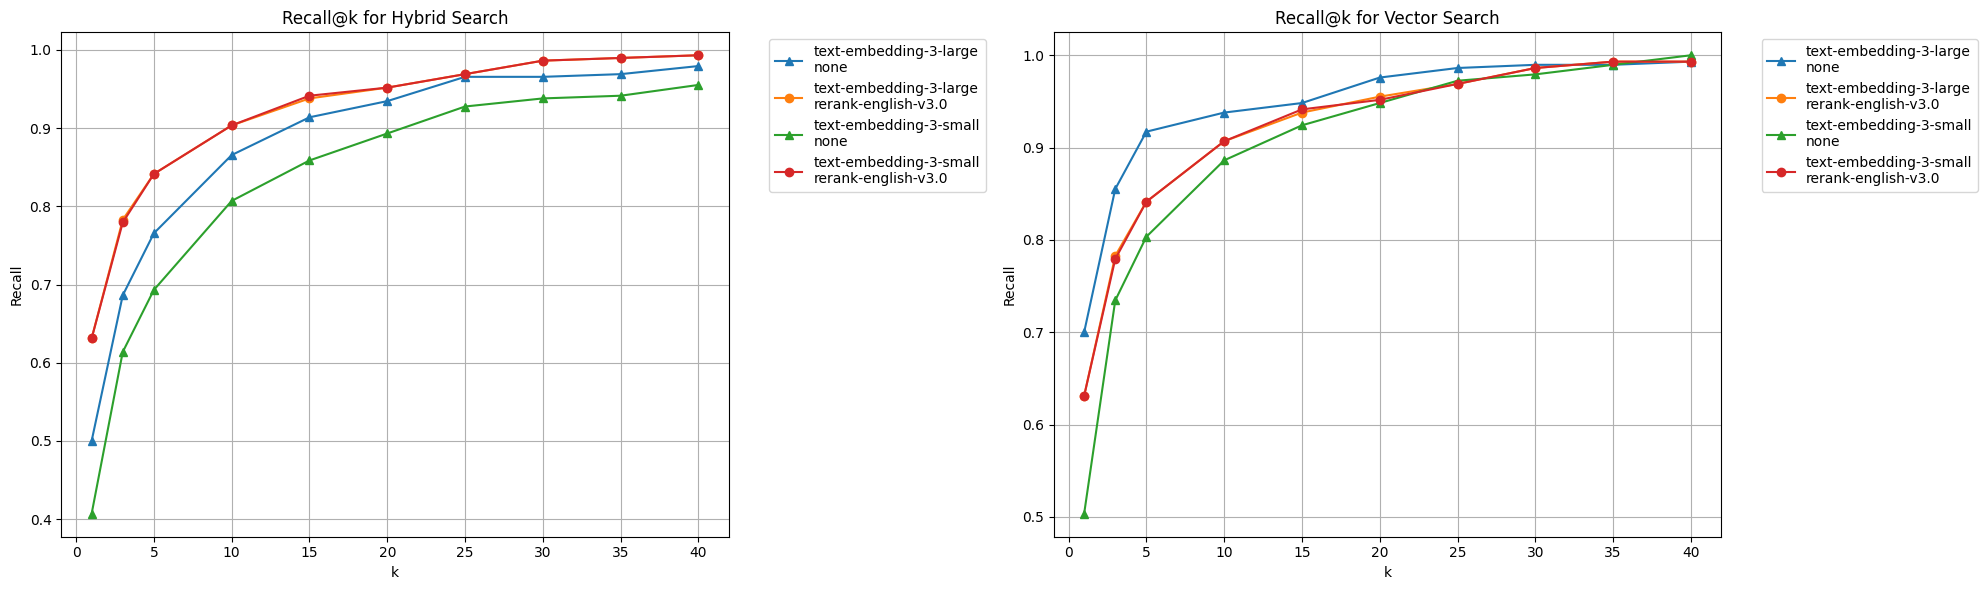

In [11]:
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot recall for hybrid search
hybrid_data = df[(df["metric"] == "recall") & (df["query_type"] == "hybrid")]
for model in sorted(df["embedding_model"].unique()):
    for reranker in sorted(df["reranker"].unique()):
        data = hybrid_data[
            (hybrid_data["reranker"] == reranker)
            & (hybrid_data["embedding_model"] == model)
        ]
        if len(data) > 0:
            marker = "o" if reranker != "none" else "^"
            ax1.plot(
                data["k"], data["score"], marker=marker, label=f"{model}\n{reranker}"
            )

ax1.set_title("Recall@k for Hybrid Search")
ax1.set_xlabel("k")
ax1.set_ylabel("Recall")
ax1.grid(True)
ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

# Plot recall for vector search
vector_data = df[(df["metric"] == "recall") & (df["query_type"] == "vector")]
for model in sorted(df["embedding_model"].unique()):
    for reranker in sorted(df["reranker"].unique()):
        data = vector_data[
            (vector_data["reranker"] == reranker)
            & (vector_data["embedding_model"] == model)
        ]
        if len(data) > 0:
            marker = "o" if reranker != "none" else "^"
            ax2.plot(
                data["k"], data["score"], marker=marker, label=f"{model}\n{reranker}"
            )

ax2.set_title("Recall@k for Vector Search")
ax2.set_xlabel("k")
ax2.set_ylabel("Recall")
ax2.grid(True)
ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

Based off the results above, we can see that text-embedding-3-large outperforms text-embedding-3-small for vector search while having a similar MRR and Recall@k for hybrid search.

With vector search, we can see that the `text-embedding-3-large` model achieves perfect recall at k=15 while a reranker only does so at k=35. We see a similar trend in hybrid search where the `text-embedding-3-large` model achieves perfect recall at k=30 while a reranker only does so at k=40.

With Hybrid Search, we can see that the `text-embedding-3-large` model achieves perfect recall at k=30 while a reranker only does so at k=40. From k=15, the `text-embedding-3-large` model outperforms or matches the reranker in terms of recall.

This suggests that for this specific set of questions

1. Embeddings search alone should be sufficient for our retrieval needs
2. A re-ranker might not be necessary for our application's initial deployment.

But this is something we wouldn't have been able to determine without running a set of experiments. Let's see another example below where we vary the number of items we pass into the re-ranker.


### How many items should we pass into the re-ranker?

We want to know how the performance of the re-ranker changes as we vary the number of items passed into it. This is important because the more items we pass into the re-ranker, the higher the latency.

Therefore, if we can get a good recall@k with a smaller `k`, we should choose that method. Let's modify our earlier code to support this.

We'll be using the text-embedding-3-small model for this experiment with vector search.


In [12]:
from braintrust import init_dataset, Eval
from lancedb.rerankers import CohereReranker
import uuid


# Load subset of evaluation queries
evaluation_queries = [
    item for item in init_dataset(project="Text-2-SQL", name="Bird-Bench-Questions-small")
]

reranker = CohereReranker(model_name="rerank-english-v3.0", column="query")
experiment_id = str(uuid.uuid4())
embedding_model = "text-embedding-3-small"
search_mode = "vector"
reranker_name = "rerank-english-v3.0"

reranker_results = []
for retrieval_limit in [40, 80, 120]:
    # Run evaluation
    benchmark_result = await Eval(
        name="Text-2-SQL",
        experiment_name=f"reranker-k-comparison-{retrieval_limit}-{experiment_id}",
        task=lambda query: retrieve(
            question=query,
            max_k=retrieval_limit,
            table=table_small,
            mode="vector",
            reranker=reranker,
        ),
        data=evaluation_queries,
        scores=[evaluate_braintrust],
        metadata={
            "retrieval_limit": retrieval_limit,
        },
    )

    # Process benchmark results
    performance_scores = benchmark_result.summary.scores
    for metric_name, score_data in performance_scores.items():
        metric_type, top_k = metric_name.split("@")
        reranker_results.append(
            {
                "metric": metric_type,
                "k": int(top_k),
                "score": score_data.score,
                "retrieval_limit": retrieval_limit,
            }
        )

Experiment reranker-k-comparison-40-a07641c2-dfea-485e-a6c0-a6abd254f6fd is running at https://www.braintrust.dev/app/Embeddiff/p/Text-2-SQL/experiments/reranker-k-comparison-40-a07641c2-dfea-485e-a6c0-a6abd254f6fd
Text-2-SQL [experiment_name=reranker-k-comparison-40-a07641c2-dfea-485e-a6c0-a6abd254f6fd] (data): 2175it [00:00, 9316.57it/s]


Text-2-SQL [experiment_name=reranker-k-comparison-40-a07641c2-dfea-485e-a6c0-a6abd254f6fd] (tasks):   0%|     …

Experiment reranker-k-comparison-80-a07641c2-dfea-485e-a6c0-a6abd254f6fd is running at https://www.braintrust.dev/app/Embeddiff/p/Text-2-SQL/experiments/reranker-k-comparison-80-a07641c2-dfea-485e-a6c0-a6abd254f6fd



=========================SUMMARY=========================
reranker-k-comparison-40-a07641c2-dfea-485e-a6c0-a6abd254f6fd compared to a7837bed-fe84-4ae6-a909-dc3695ce12ab-none-vector-text-embedding-3-large:
64.60% (-06.19%) 'mrr@1'     score	(28 improvements, 46 regressions)
71.82% (-06.64%) 'mrr@3'     score	(39 improvements, 59 regressions)
73.19% (-06.63%) 'mrr@5'     score	(44 improvements, 65 regressions)
74.12% (-05.99%) 'mrr@10'    score	(48 improvements, 67 regressions)
74.30% (-05.72%) 'mrr@15'    score	(51 improvements, 67 regressions)
74.39% (-05.77%) 'mrr@20'    score	(53 improvements, 67 regressions)
74.45% (-05.77%) 'mrr@25'    score	(55 improvements, 67 regressions)
74.47% (-05.76%) 'mrr@30'    score	(55 improvements, 67 regressions)
74.48% (-05.75%) 'mrr@35'    score	(55 improvements, 67 regressions)
74.48% (-05.76%) 'mrr@40'    score	(55 improvements, 67 regressions)
64.60% (-06.19%) 'recall@1'  score	(28 improvements, 46 regressions)
80.69% (-06.53%) 'recall@3'  score	

Text-2-SQL [experiment_name=reranker-k-comparison-80-a07641c2-dfea-485e-a6c0-a6abd254f6fd] (data): 2175it [00:00, 123373.56it/s]


Text-2-SQL [experiment_name=reranker-k-comparison-80-a07641c2-dfea-485e-a6c0-a6abd254f6fd] (tasks):   0%|     …

Evaluator Text-2-SQL [experiment_name=reranker-k-comparison-80-a07641c2-dfea-485e-a6c0-a6abd254f6fd] failed with 6 errors
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/braintrust/framework.py", line 1114, in run_evaluator_task
    output = await await_or_run(event_loop, evaluator.task, *task_args)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/braintrust/framework.py", line 362, in await_or_run
    return await event_loop.run_in_executor(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/concurrent/futures/thread.py", line 58, in run
    result = self.fn(*self.args, **self.kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/braintrust/framework.py", line 356, in run_f
    return f(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^
  File "<ipython-input-12-6160cc66868b>", line 23, in <lambda>
    task=lambda

Text-2-SQL [experiment_name=reranker-k-comparison-120-a07641c2-dfea-485e-a6c0-a6abd254f6fd] (tasks):   0%|    …


=========================SUMMARY=========================
reranker-k-comparison-120-a07641c2-dfea-485e-a6c0-a6abd254f6fd compared to reranker-k-comparison-80-a07641c2-dfea-485e-a6c0-a6abd254f6fd:
63.82% (-00.22%) 'mrr@1'     score	(0 improvements, 6 regressions)
70.99% (-00.22%) 'mrr@3'     score	(0 improvements, 16 regressions)
72.39% (-00.20%) 'mrr@5'     score	(0 improvements, 21 regressions)
73.27% (-00.23%) 'mrr@10'    score	(0 improvements, 41 regressions)
73.46% (-00.23%) 'mrr@15'    score	(0 improvements, 55 regressions)
73.52% (-00.23%) 'mrr@20'    score	(0 improvements, 68 regressions)
73.56% (-00.25%) 'mrr@25'    score	(0 improvements, 93 regressions)
73.60% (-00.24%) 'mrr@30'    score	(0 improvements, 105 regressions)
73.61% (-00.24%) 'mrr@35'    score	(0 improvements, 114 regressions)
73.62% (-00.24%) 'mrr@40'    score	(0 improvements, 119 regressions)
63.82% (-00.22%) 'recall@1'  score	(0 improvements, 6 regressions)
79.86% (-00.17%) 'recall@3'  score	(0 improvements, 5 

In [ ]:
reranker_df = pd.DataFrame(reranker_results)

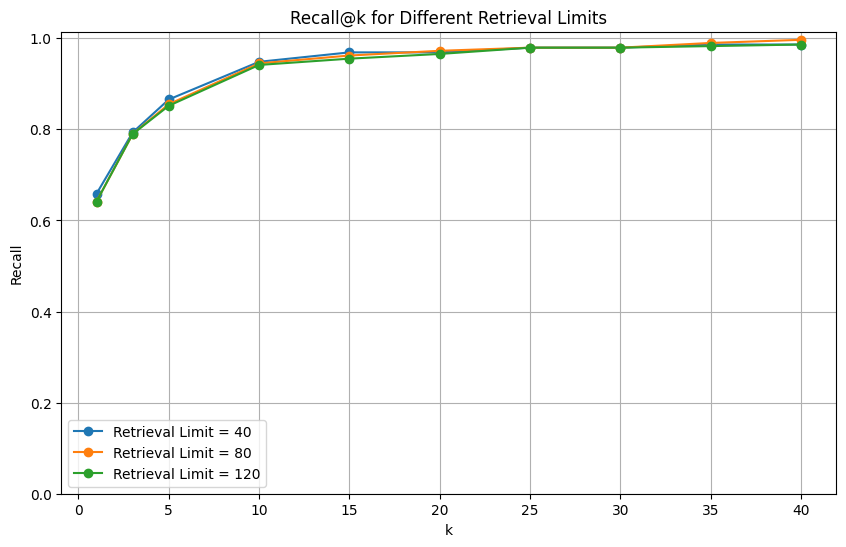

In [ ]:
# Filter for recall metric and create plot
recall_df = reranker_df[reranker_df["metric"] == "recall"]
limits_to_plot = [40, 80, 120]

plt.figure(figsize=(10, 6))
for limit in limits_to_plot:
    data = recall_df[recall_df["retrieval_limit"] == limit]
    plt.plot(data["k"], data["score"], label=f"Retrieval Limit = {limit}", marker="o")

plt.xlabel("k")
plt.ylabel("Recall")
plt.title("Recall@k for Different Retrieval Limits")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

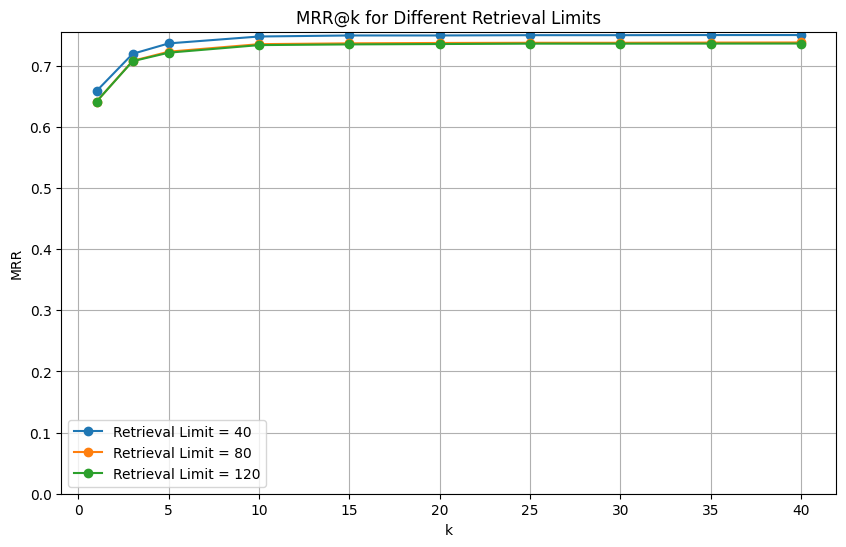

In [ ]:
# Filter for recall metric and create plot
recall_df = reranker_df[reranker_df["metric"] == "mrr"]
limits_to_plot = [40, 80, 120]

plt.figure(figsize=(10, 6))
for limit in limits_to_plot:
    data = recall_df[recall_df["retrieval_limit"] == limit]
    plt.plot(data["k"], data["score"], label=f"Retrieval Limit = {limit}", marker="o")

plt.xlabel("k")
plt.ylabel("MRR")
plt.title("MRR@k for Different Retrieval Limits")
plt.legend()
plt.grid(True)
plt.ylim(bottom=0)
plt.show()

## Conclusion

Our analysis showed that increasing items passed to the re-ranker yielded minimal gains. This fits into a broader pattern of findings from our rigorous comparison of different retrieval strategies:

1. Embedding search outperformed hybrid search in both recall and MRR metrics
2. The choice of embedding model significantly impacted performance
3. Re-ranking provided minimal benefits for our specific use case

These methods provide a foundation for Week 2's fine-tuning work and Week 4's query understanding systems. Early evaluation helps us make informed decisions about which methods to use, this is especially valuable as our RAG system grows more sophisticated.

Remember that these results are specific to our test dataset - your evaluations may yield different insights. In the next notebook, we'll explore statistical techniques to validate that these performance differences are meaningful.
